In [14]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal

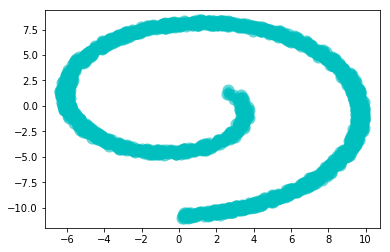

In [4]:
X = np.loadtxt("Synthetic Data/class1.txt")

plt.scatter(X[: , 0], X[:, 1], s=50, c = 'c', marker = 'o', linewidths = 5, zorder = 10, alpha = 0.6)
plt.show()  

#### Determine K from KMeans

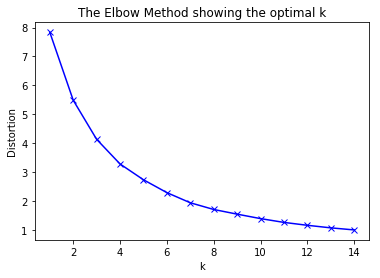

In [5]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

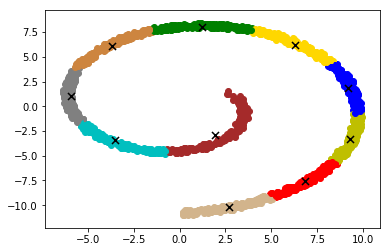

In [6]:
cluster_size = 10
clf = KMeans(n_clusters = cluster_size)
clf.fit(X)

# Gives the final cetnroids of each cluster
centroids = clf.cluster_centers_

# Label of each data-point
labels = clf.labels_


colors = 10*["g", "r", "c", "b", "y","gray", "brown", "tan", "gold", "peru", "tomato", "aqua"]
for i in range(len(X)):
    plt.scatter(X[i][0], X[i][1], c = colors[labels[i]], marker = 'o')

plt.scatter(centroids[:, 0], centroids[:, 1], c= 'k', marker = 'x', s = 50,  zorder = 10)
plt.show()  

In [7]:
clusters = {}

#initialize
for i in range(cluster_size):
    clusters[i] = []

for i,j in zip(X, labels):
    clusters[j].append(i)

for i in clusters:
    clusters[i] = np.array(clusters[i])

#### Visualize Clustering

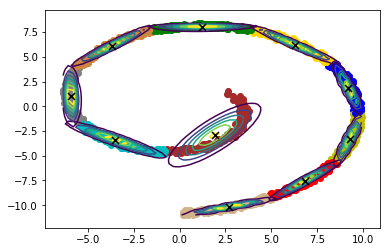

In [8]:
# Our 2-dimensional distribution will be over variables X[0] and X[1]
N = 60
xs = np.linspace(min(X[:,0]), max(X[:,0]), N)
ys = np.linspace(min(X[:,1]), max(X[:,1]), N)
xs, ys = np.meshgrid(xs, ys)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(xs.shape + (2,))
pos[:, :, 0] = xs
pos[:, :, 1] = ys

def multivariate_gaussian(pos, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# Mean vector and covariance matrix
for index in range(cluster_size):
    mu = centroids[index]
    Sigma = np.cov(np.transpose(clusters[index]))

    # The distribution on the variables X, Y packed into pos.
    Z = multivariate_gaussian(pos, mu, Sigma)

    plt.contour(xs, ys, Z)

for i in range(len(X)):
    plt.scatter(X[i][0], X[i][1], c = colors[labels[i]], marker = 'o')
plt.scatter(centroids[:, 0], centroids[:, 1], c= 'k', marker = 'x', s = 50,  zorder = 10)    
plt.show()

#### Steps

1. KMeans
2. Calculate πk
3. Calculate γ(znk)
4. Calculate new Mean and Sigma 

<img src="EMStep.png" width="600px">

In [41]:
# generalised functions

def cal_pi_k(clusters):
    '''Calculate pi_k(new) after an iteration from Expectation step or initial KMeans step '''
    pi_k = []
    for i in clusters:
        pi_k.append(clusters[i].shape[0])
    return np.array(pi_k)/X.shape[0]

def recal_pi_k(gamma):
    k_size = gamma.shape[1]
    n_size = gamma.shape[0]
    mix = [0]*k_size
    for i in range(k_size):
        mix[i] = sum(gamma[:,i])/n_size
        
    return mix
        

def cal_mu(X, gamma, centroids):
    '''Calculate Mu(new) after an iteration from Expectation step or initial KMeans step '''
    
    cluster_size = len(centroids)
    new_centroids = centroids
    
    for k in range(cluster_size):
        temp_sum= sum(gamma[:,k])
        temp_s = np.array([0,0], dtype='float64')
        for n in range(X.shape[0]):
            temp_s+=gamma[n][k]*X[n]
        if temp_sum > 1:
            new_centroids[k] = temp_s/temp_sum
    
    return new_centroids

def build_gamma(X, clusters, centroids, mix):
    
    cluster_size = len(clusters)
    tmp = np.zeros([X.shape[0], cluster_size])
    
    for i in range(cluster_size):
        mean = centroids[i]
        cov = np.cov(np.transpose(clusters[i]))
        U = (X - np.mean(X)) / np.std(X)
        tmp[:, i] = mix[i]*multivariate_normal.pdf(U, mean, cov)
        
    gamma = np.zeros([X.shape[0], cluster_size])

    for i in range(X.shape[0]):
        temp_sum = sum(tmp[i, :])
        for j in range(cluster_size):
            gamma[i][j] = tmp[i][j] / temp_sum
            
    return gamma

def rebuild_gamma(X, centroids, mix):
    
    cluster_size = len(clusters)
    tmp = np.zeros([X.shape[0], cluster_size])
    
    for i in range(cluster_size):
        mean = centroids[i]
        cov = np.cov(np.transpose(clusters[i]))
        U = (X - np.mean(X)) / np.std(X)
        tmp[:, i] = mix[i]*multivariate_normal.pdf(U, mean, cov)
        
    gamma = np.zeros([X.shape[0], cluster_size])

    for i in range(X.shape[0]):
        temp_sum = sum(tmp[i, :])
        for j in range(cluster_size):
            gamma[i][j] = tmp[i][j] / temp_sum
            
    return gamma

In [42]:
pi = cal_pi_k(clusters)
gamma = build_gamma(X, clusters, centroids, pi)
new_centroids = cal_mu(X, gamma, centroids)

#If doesn't converge iterate
#pi = recal_pi_k(gamma)


In [44]:
centroids

array([[  1.20596148,   8.031319  ],
       [  6.84196869,  -7.52111168],
       [ -3.51393233,  -3.37533068],
       [  9.21025913,   1.81585007],
       [  9.27626261,  -3.29781207],
       [ -5.93321508,   1.02961827],
       [  2.68262722,  -0.43167162],
       [  2.70691202, -10.14522752],
       [  6.30398861,   6.21048911],
       [ -3.71912064,   6.11622064]])

#### Gaussian mixtures

In [ ]:
a={1:2, 2:3}